# Natural Scenes classification

## Srijan Mallick
## M.Sc. BDA 1st year



### This is an image classification problem, obtained from Kaggle.
### The dataset consists of 6 classes : Mountain, Sea, Glacier, Street, Buildings and Forest

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import sys
from PIL import Image
import cv2
import csv
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid
import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

# Loading Google drive to Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Unzipping data folder

In [3]:
!unzip /content/gdrive/MyDrive/intel_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [4]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
train_dir = '/content/seg_test/seg_test'
test_dir = '/content/seg_pred/seg_pred'

# Creating dataframe with data stats

In [6]:
classes = []
for i in os.listdir(train_dir):
  classes.append(i)
classes

['sea', 'buildings', 'street', 'glacier', 'mountain', 'forest']

In [7]:
n_train = []
n_test = []
for c in classes:
  train_images = os.listdir(train_dir + '/' + c)
  n_train.append(len(train_images))
  test_images = os.listdir(test_dir + '/' + c)
  n_test.append(len(test_images))

In [8]:
print(n_train)

[510, 437, 501, 553, 525, 474]


In [9]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train})
print(data)

     Classes  Train
0        sea    510
1  buildings    437
2     street    501
3    glacier    553
4   mountain    525
5     forest    474


# Visualising data stats

Text(0.5, 1.0, 'Training data')

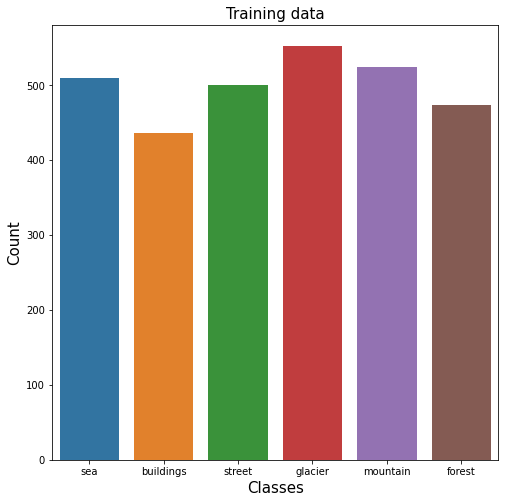

In [10]:
plt.figure(figsize=(8,8))
sns.barplot(data=data, x='Classes', y='Train')
plt.xlabel('Classes', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Training data', fontsize = 15)

# Creating dataframe from images and labels


In [11]:
# train set

ptrain = []
ctrain = []
for folder_name in os.listdir(train_dir + '/'):
  for files in os.listdir(train_dir + '/' + folder_name):
    if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
        path = train_dir + '/' + folder_name + '/' + files
        clss = folder_name
        ptrain.append(path)
        ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in os.listdir(test_dir + '/'):
  for files in os.listdir(test_dir + '/' + folder_name):
    if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
        path = test_dir + '/' + folder_name + '/' + files
        clss = folder_name
        ptest.append(path)
        ctest.append(clss)

In [12]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)

,Path,Class
0,/content/seg_test/seg_test/sea/20472.jpg,sea
1,/content/seg_test/seg_test/sea/22746.jpg,sea
2,/content/seg_test/seg_test/sea/20530.jpg,sea
3,/content/seg_test/seg_test/sea/20289.jpg,sea
4,/content/seg_test/seg_test/sea/22121.jpg,sea
5,/content/seg_test/seg_test/sea/22439.jpg,sea
6,/content/seg_test/seg_test/sea/23089.jpg,sea
7,/content/seg_test/seg_test/sea/23093.jpg,sea
8,/content/seg_test/seg_test/sea/20679.jpg,sea
9,/content/seg_test/seg_test/sea/20264.jpg,sea


# Visualising the data

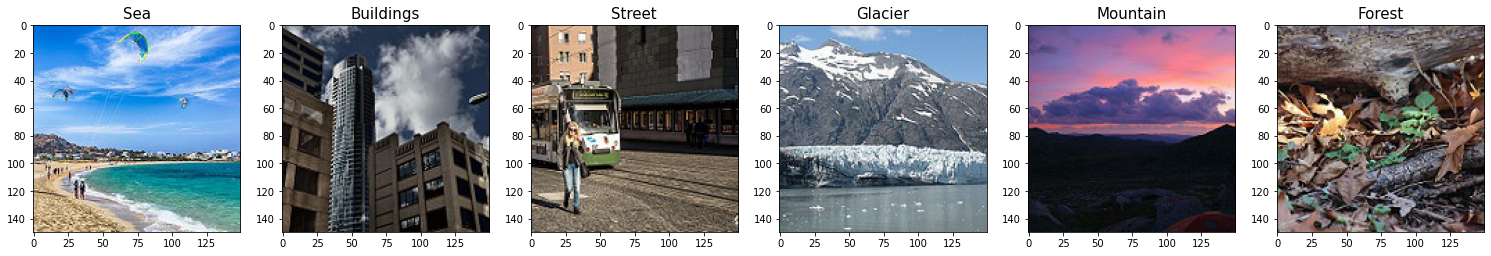

In [13]:
plt.figure(figsize=(26,26))
for j in range(6):
  plt.subplot(1,6,j+1)
  im = os.listdir(train_dir + '/' + classes[j] + '/')[0]
  im2 = plt.imread(train_dir + '/' + classes[j] + '/' + im)
  plt.imshow(im2)
  plt.title(str(classes[j]).capitalize(),size=15)

# Transformation for data augumentation


In [14]:
train_transforms_res = transforms.Compose([transforms.Resize((150,150)),
                                           transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
                                           transforms.ColorJitter(0.3,0.4,0.4,0.2),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))]) 

test_transforms_res = transforms.Compose([
                                          transforms.Resize((150,150)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
                                          ])

In [15]:
train_data = datasets.ImageFolder(train_dir, transform = train_transforms_res)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms_res)

# Splitting training data into training and validation sets

In [16]:
# training indices to be used for validation

num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 
print(train_idx)
print(valid_idx)

3000
600
[2828, 1324, 806, 315, 2378, 545, 1530, 2973, 2735, 587, 2996, 1175, 1910, 795, 1056, 2648, 976, 2235, 2167, 986, 2070, 188, 467, 815, 428, 2061, 2460, 2187, 1314, 313, 1532, 1829, 375, 1959, 1984, 1796, 1088, 1812, 398, 934, 366, 2791, 2569, 1985, 1084, 136, 2495, 2245, 1967, 2499, 987, 843, 2870, 1394, 8, 778, 1112, 2157, 1657, 2032, 2169, 299, 2562, 2049, 1766, 1093, 539, 1002, 2755, 1198, 210, 43, 1750, 2994, 2516, 1214, 179, 1977, 1505, 688, 2628, 1820, 1886, 2146, 73, 2714, 400, 884, 272, 2355, 2365, 2016, 2945, 1609, 1167, 704, 658, 834, 1901, 52, 132, 1605, 2687, 2467, 2986, 2142, 2697, 2343, 483, 1855, 485, 1989, 493, 21, 974, 707, 2002, 712, 744, 2822, 1286, 1020, 1229, 2651, 1496, 1347, 72, 858, 2517, 1920, 1041, 2211, 952, 88, 1436, 1809, 2419, 2645, 915, 2135, 1383, 2331, 16, 555, 1790, 2013, 908, 98, 1172, 2251, 914, 2486, 2781, 69, 2614, 1893, 2995, 955, 501, 371, 808, 2330, 1145, 643, 1288, 839, 1339, 1069, 2285, 2233, 2753, 1793, 2310, 532, 327, 928, 1723, 239

In [ ]:
'''
num_train = len(train_idx)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); 
train_idx, valid_idx = indices[split:], indices[:split] 
print(len(train_idx))
print(len(valid_idx))
print(train_idx)
print(valid_idx)
'''

'\nnum_train = len(train_idx)\nindices = list(range(num_train))\nnp.random.shuffle(indices)\nsplit = int(np.floor(0.2 * num_train)); \ntrain_idx, valid_idx = indices[split:], indices[:split] \nprint(len(train_idx))\nprint(len(valid_idx))\nprint(train_idx)\nprint(valid_idx)\n'

In [17]:
# defining samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
# loading the data 

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 60, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 60, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[ 1.1023,  1.1215,  1.1215,  ...,  2.2501,  2.2501,  2.2692],
           [ 1.1406,  1.1406,  1.1406,  ...,  2.2501,  2.2692,  2.2692],
           [ 1.1406,  1.1406,  1.1406,  ...,  2.2692,  2.2692,  2.2692],
           ...,
           [-1.1932, -0.3515, -0.4472,  ...,  1.3702,  0.8154,  1.5997],
           [-0.1985, -1.1549, -0.6958,  ...,  0.9493,  0.7771,  0.4137],
           [-0.4089,  0.4137, -0.5811,  ...,  0.0311,  0.2415,  1.2554]],
 
          [[ 1.7441,  1.7633,  1.7633,  ...,  2.6050,  2.6050,  2.6241],
           [ 1.8207,  1.8207,  1.8207,  ...,  2.6050,  2.6241,  2.6241],
           [ 1.8207,  1.8207,  1.8207,  ...,  2.6241,  2.6241,  2.6241],
           ...,
           [-0.5132,  0.2520,  0.1755,  ...,  1.3807,  0.8068,  1.5528],
           [ 0.5198, -0.5323, -0.0923,  ...,  1.0746,  0.9024,  0.5390],
           [ 0.2903,  1.0363, -0.0540,  ...,  0.2138,  0.4433,  1.5146]],
 
          [[ 2.6920,  2.6920,  2.6920,  ...,  2.7685,  2.7685,  2.7685],
           [ 

In [19]:
def show_images(dataloader): 
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
    break
def accuracy(output, target):
  output = torch.exp(output)
  top_p,top_class = output.topk(1,dim = 1)
  equals = top_class == target.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


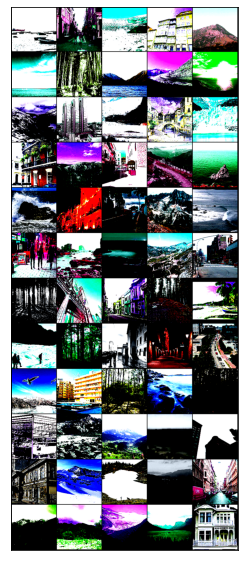

In [20]:
show_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


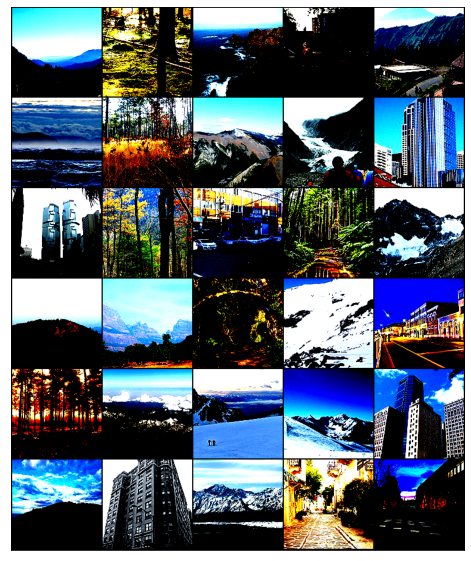

In [21]:
show_images(test_loader)

# Defining the architecture

In [22]:
class IntelImageNet(nn.Module):
  def __init__(self):
    super(IntelImageNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.conv2 = nn.Conv2d(16,32, 3, padding = 1)
    self.conv3 = nn.Conv2d(32,64, 3, padding = 1)
    self.conv4 = nn.Conv2d(64,64, 3, padding = 1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*9*9, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 6)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1,64*9*9) 
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

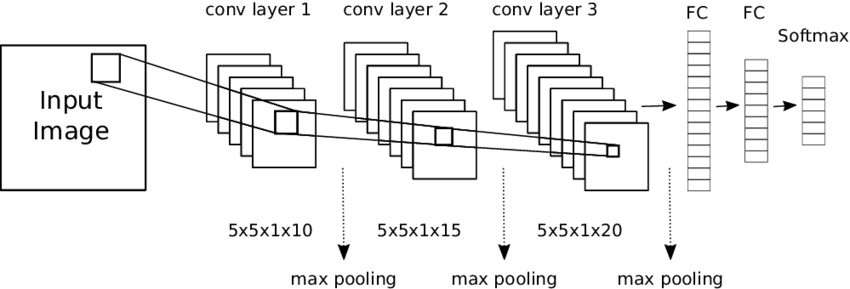

# SGD Optimiser

Mini-batch gradient descent [Stochastic gradient descent (SGD)] performs a parameter update for every mini-batch of training examples.


$\theta = \theta - \eta \cdot \nabla_\theta J( \theta; x^{(i:i+n)}; y^{(i:i+n)})$

SGD attempts to estimate the gradient of the cost function w.r.t. to the parameters $\theta$ for the entire training dataset by taking these small batches. Thus it is computationally lighter than GD.

# 1 i) Using Vanilla SGD optimiser with small learning rate (0.01)

In [ ]:
model = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(model.parameters(), lr = 0.01)

# specifying scheduler

#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.06)

if train_on_gpu:
    model.cuda()

print(model)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel.pt')
        valid_loss_min = valid_loss

/home/sysadm/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 107.451317 	Validation Loss: 107.361461 
		Training Accuracy: 0.157500 	Validation Accuracy: 0.160000
Validation loss decreased (inf --> 107.361461).  Saving model ...
Epoch: 2 	Training Loss: 107.377566 	Validation Loss: 107.319658 
		Training Accuracy: 0.172500 	Validation Accuracy: 0.148333
Validation loss decreased (107.361461 --> 107.319658).  Saving model ...
Epoch: 3 	Training Loss: 107.292719 	Validation Loss: 107.227762 
		Training Accuracy: 0.169583 	Validation Accuracy: 0.208333
Validation loss decreased (107.319658 --> 107.227762).  Saving model ...
Epoch: 4 	Training Loss: 107.231608 	Validation Loss: 107.182109 
		Training Accuracy: 0.177917 	Validation Accuracy: 0.218333
Validation loss decreased (107.227762 --> 107.182109).  Saving model ...
Epoch: 5 	Training Loss: 107.169296 	Validation Loss: 107.037472 
		Training Accuracy: 0.196250 	Validation Accuracy: 0.238333
Validation loss decreased (107.182109 --> 107.037472).  Saving model ...
Epoch: 

# Plotting training/validation losses and accuracy
# and gradients of weight and bias


Text(0.5, 1.0, 'Distribution of gradients in last fully connected layer in \nVanilla SGD, learning rate = 0.01')

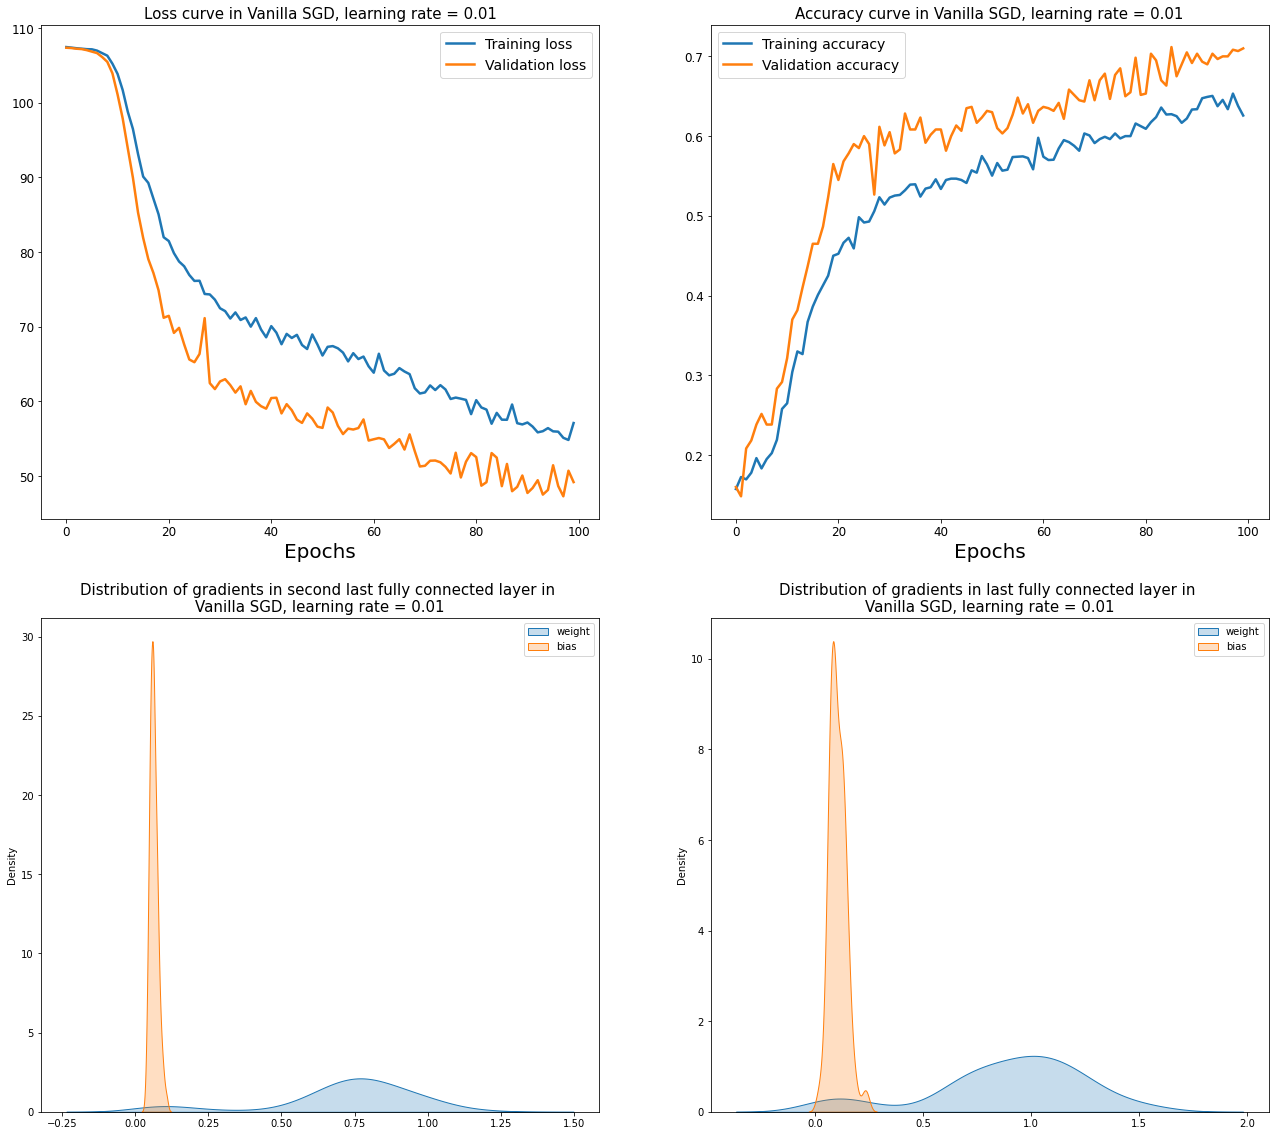

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in Vanilla SGD, learning rate = 0.01", size=15)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in Vanilla SGD, learning rate = 0.01", size=15)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in second last fully connected layer in \nVanilla SGD, learning rate = 0.01", size=15)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in last fully connected layer in \nVanilla SGD, learning rate = 0.01", size=15)

The loss curve has not stabilised, and it continues to decrease. Increasing the number of epochs might take us to a more desirable result. The other alternative is to increse the learning rate, which I have implemented next.

# Loading model with lowest validation loss

In [ ]:
model.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel.pt'))

<All keys matched successfully>

# Testing the model

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.777578

Test Accuracy of mountain: 75% (331/437)
Test Accuracy of   sea: 88% (421/474)
Test Accuracy of glacier: 56% (311/553)
Test Accuracy of street: 70% (372/525)
Test Accuracy of buildings: 51% (264/510)
Test Accuracy of forest: 82% (413/501)

Test Accuracy (Overall): 70% (2112/3000)


# Evaulating the model

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[331.,  11.,   8.,   7.,   2.,  78.],
        [ 10., 421.,   2.,   5.,   0.,  36.],
        [ 20.,   4., 311.,  62., 150.,   6.],
        [ 34.,   2.,  35., 372.,  79.,   3.],
        [ 31.,   3.,  90., 117., 264.,   5.],
        [ 59.,  16.,   9.,   4.,   0., 413.]])


Text(69.0, 0.5, 'TRUE')

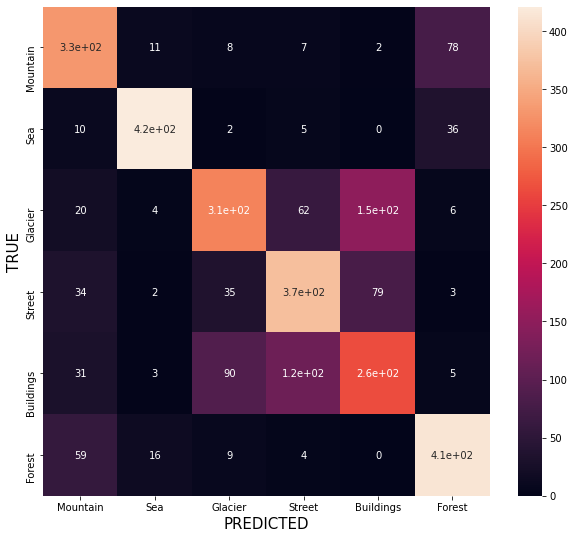

In [ ]:
plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(confusion_matrix, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

 # 1 ii) Using Vanilla SGD optimiser with large learning rate (0.1)

In [ ]:
model2 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(model2.parameters(), lr = 0.1)

# specifying scheduler

#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.06)

if train_on_gpu:
    model2.cuda()

print(model2)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model2.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model2.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model2.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model2.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model2.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model2.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model2.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 106.985203 	Validation Loss: 105.053013 
		Training Accuracy: 0.206250 	Validation Accuracy: 0.391667
Validation loss decreased (inf --> 105.053013).  Saving model ...
Epoch: 2 	Training Loss: 101.418152 	Validation Loss: 91.388623 
		Training Accuracy: 0.294167 	Validation Accuracy: 0.443333
Validation loss decreased (105.053013 --> 91.388623).  Saving model ...
Epoch: 3 	Training Loss: 93.719635 	Validation Loss: 80.009324 
		Training Accuracy: 0.361667 	Validation Accuracy: 0.448333
Validation loss decreased (91.388623 --> 80.009324).  Saving model ...
Epoch: 4 	Training Loss: 89.030395 	Validation Loss: 77.097724 
		Training Accuracy: 0.394583 	Validation Accuracy: 0.445000
Validation loss decreased (80.009324 --> 77.097724).  Saving model ...
Epoch: 5 	Training Loss: 86.005273 	Validation Loss: 89.240414 
		Training Accuracy: 0.409583 	Validation Accuracy: 0.413333
Epoch: 6 	Training Loss: 81.698145 	Validation Loss: 72.741879 
		Training Accuracy: 0.45041

# Plotting training/validation losses and accuracy
# and gradients of weight and bias

Text(0.5, 1.0, 'Distribution of gradients in last fully connected layer in \n Vanilla SGD, learning rate = 0.1')

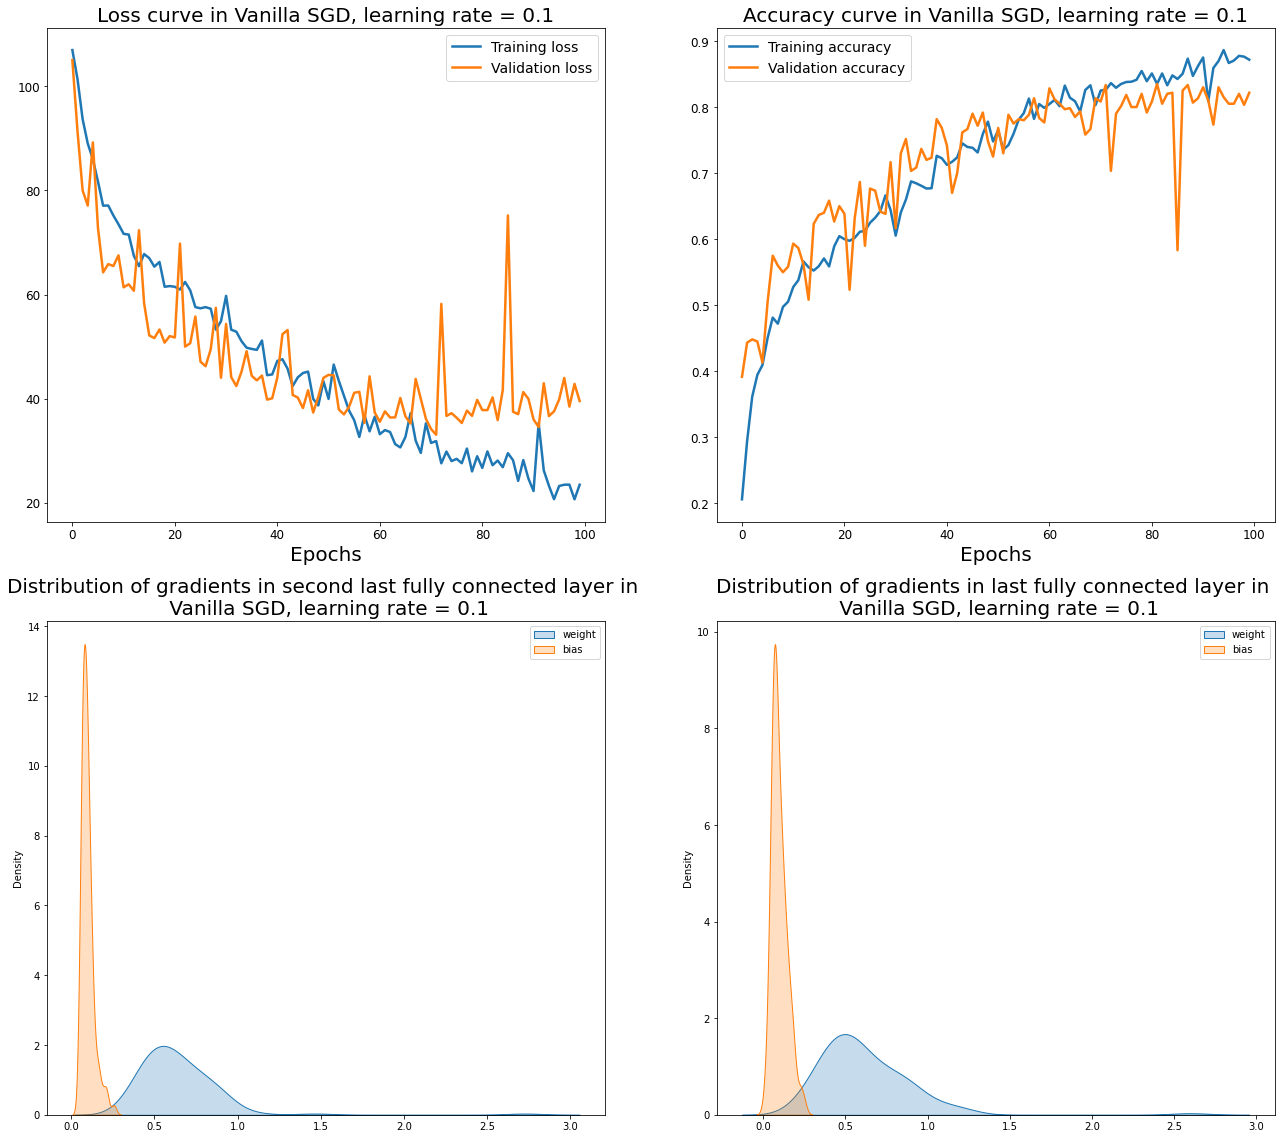

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in Vanilla SGD, learning rate = 0.1",size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in Vanilla SGD, learning rate = 0.1",size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in second last fully connected layer in \n Vanilla SGD, learning rate = 0.1",size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in last fully connected layer in \n Vanilla SGD, learning rate = 0.1",size=20)

With a large learning rate, the loss has now come down much faster, but we can observe 2 things from the loss curve :

- The loss curve shows a high oscillation throughout
- The validation loss begins to increase after 60 epochs, ie, the model begins to overfit the data

The first problem occurs because in mini batch GD, we take a sample of the data and labels, construct the loss function based on that data and perform GD. So, for every mini batch, the loss function is different, with each minima being quite different from the actual minima of the loss function constructed from the entire data. As we cover more and more data over iterations, we come closer to reconstructing / estimating the actual loss function. Hence, SGD shows much more oscillating loss curve.

The second problem can be taken care of easily by including a regularisation parameter in our model.


# Testing the model

In [ ]:
model2.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel2.pt'))

# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model2.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model2(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.226936

Test Accuracy of mountain: 96% (423/437)
Test Accuracy of   sea: 98% (467/474)
Test Accuracy of glacier: 94% (520/553)
Test Accuracy of street: 84% (442/525)
Test Accuracy of buildings: 90% (463/510)
Test Accuracy of forest: 95% (478/501)

Test Accuracy (Overall): 93% (2793/3000)


# Evaulating the model

Text(69.0, 0.5, 'TRUE')

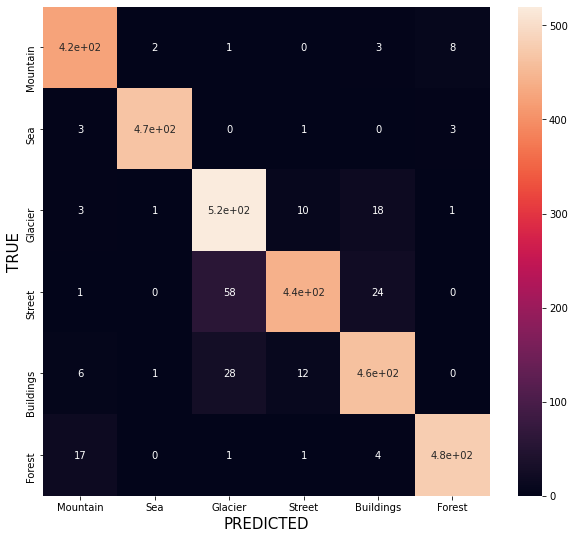

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model2(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(confusion_matrix, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

Now, we shall try to rectify the problems in our previous approach one by one. First, we shall introduce a momentum term in our SGD, and afterwards, a regularisation parameter.

 SGD has trouble navigating areas where the surface curves much more steeply in one dimension than in another. In these scenarios, SGD oscillates across the slopes of one direction while only making hesitant progress along another direction. This is where momentum helps.

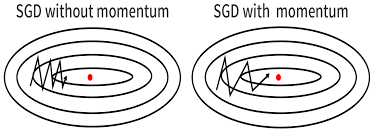




\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}

# 2 i) Using SGD optimiser with momentum = 0.9 and small learning rate (0.01)

In [ ]:
model3 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(model3.parameters(), lr = 0.01, momentum = 0.9)

# specifying scheduler

#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.06)

if train_on_gpu:
    model3.cuda()

print(model3)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model3.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model3.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model3.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model3.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model3.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model3.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model3.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel3.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 107.188834 	Validation Loss: 106.390833 
		Training Accuracy: 0.193750 	Validation Accuracy: 0.198333
Validation loss decreased (inf --> 106.390833).  Saving model ...
Epoch: 2 	Training Loss: 101.967667 	Validation Loss: 89.743927 
		Training Accuracy: 0.288333 	Validation Accuracy: 0.393333
Validation loss decreased (106.390833 --> 89.743927).  Saving model ...
Epoch: 3 	Training Loss: 90.350483 	Validation Loss: 79.607385 
		Training Accuracy: 0.379167 	Validation Accuracy: 0.451667
Validation loss decreased (89.743927 --> 79.607385).  Saving model ...
Epoch: 4 	Training Loss: 82.562689 	Validation Loss: 73.556062 
		Training Accuracy: 0.423333 	Validation Accuracy: 0.545000
Validation loss decreased (79.607385 --> 73.556062).  Saving model ...
Epoch: 5 	Training Loss: 79.073765 	Validation Loss: 68.318516 
		Training Accuracy: 0.441250 	Validation Accuracy: 0.538333
Validation loss decreased (73.556062 --> 68.318516).  Saving model ...
Epoch: 6 	Training Lo

# Plotting training/validation losses and accuracy 
# and gradients of weight and bias

Text(0.5, 1.0, 'Distribution of gradients in last fully connected layer in SGD with momentum = 0.9, learning rate = 0.01')

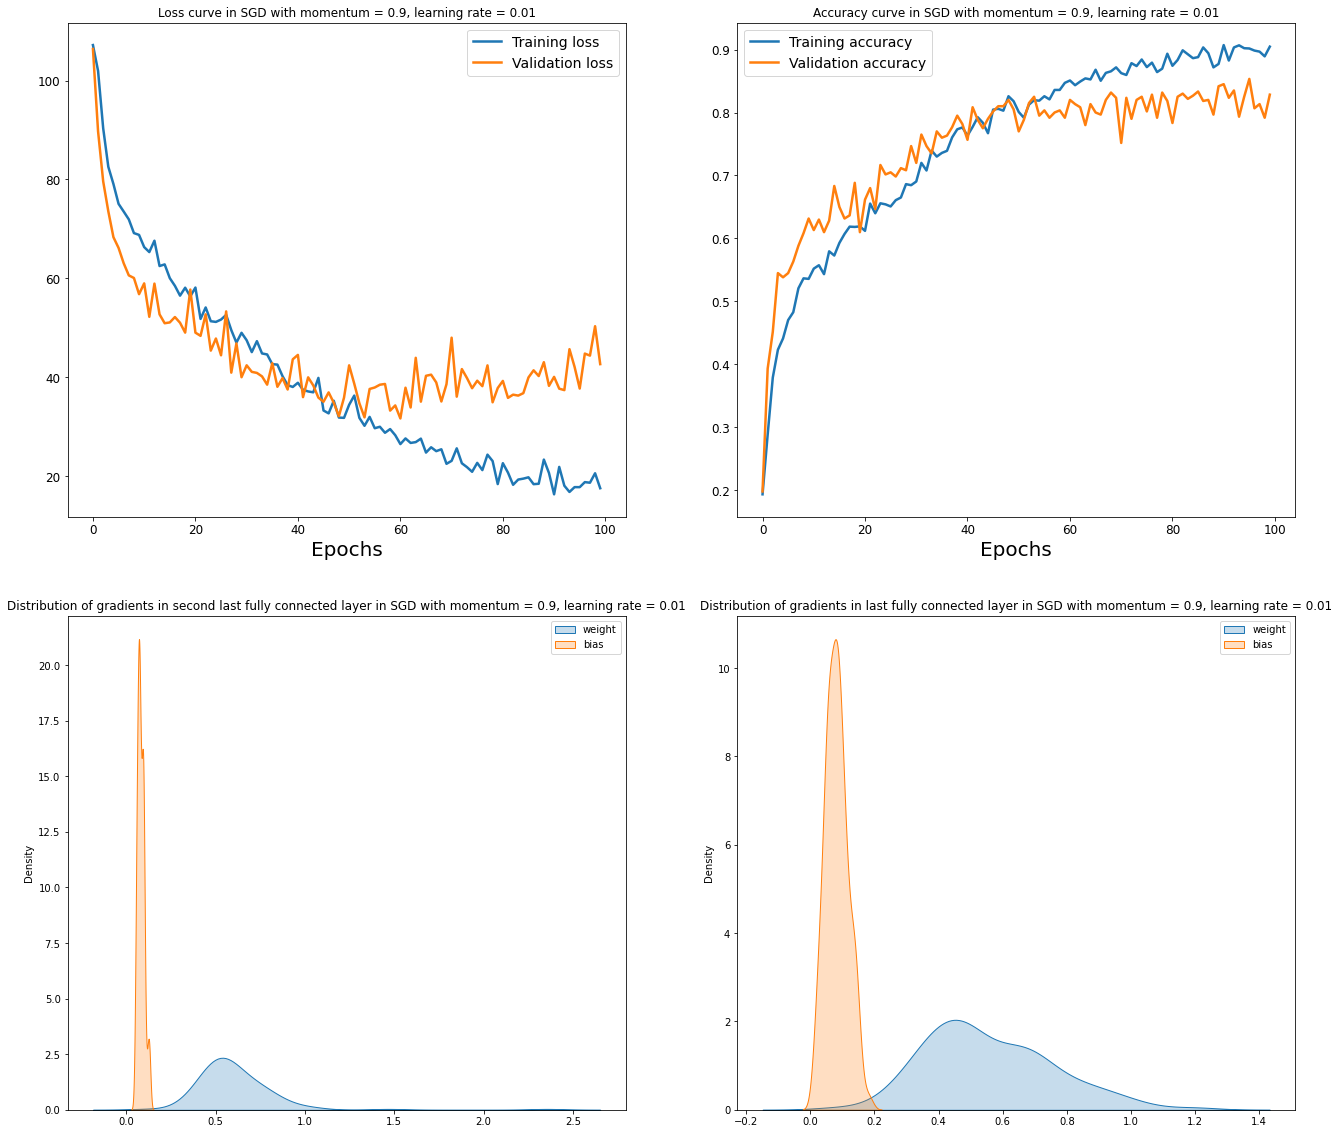

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in SGD with momentum = 0.9, learning rate = 0.01")

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in SGD with momentum = 0.9, learning rate = 0.01")

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in second last fully connected layer in SGD with momentum = 0.9, learning rate = 0.01")

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in last fully connected layer in SGD with momentum = 0.9, learning rate = 0.01")

We observe that the training loss curve is now much smoother, but the overfitting problem remains the same. Hence, we shall introduce an L2 regularisation term with the loss next.

# Testing the model

In [ ]:
model3.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel3.pt'))

# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model3.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model3(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.217319

Test Accuracy of mountain: 94% (415/437)
Test Accuracy of   sea: 99% (471/474)
Test Accuracy of glacier: 86% (481/553)
Test Accuracy of street: 90% (473/525)
Test Accuracy of buildings: 95% (488/510)
Test Accuracy of forest: 96% (481/501)

Test Accuracy (Overall): 93% (2809/3000)


# Evaluating the model

Text(69.0, 0.5, 'TRUE')

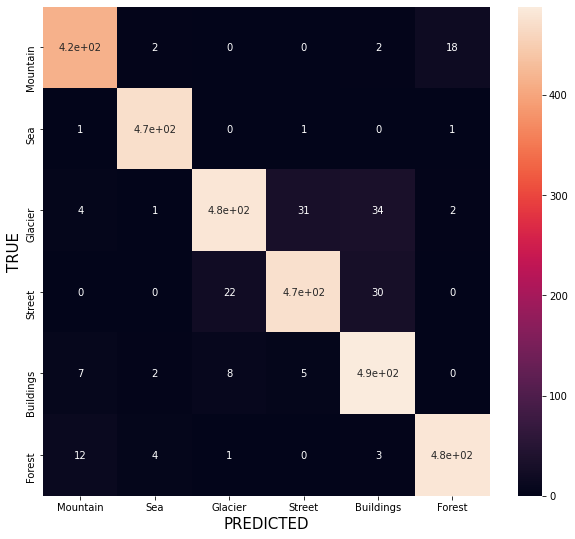

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model3(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(confusion_matrix, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

# 2 ii) Using SGD optimiser with momentum = 0.9, small learning rate (0.01) and L2 regularisation (weight decay = 0.01)

In [ ]:
model4 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(model4.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.01)
#optimizer = optim.SGD(model4.parameters(), lr = 0.1, momentum = 0.99, weight_decay = 0.2)

# specifying scheduler

#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.06)

if train_on_gpu:
    model4.cuda()

print(model4)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
)

# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 70

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model4.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model4(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model4.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model4(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model4.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model4.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model4.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model4.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model4.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel4.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 107.170544 	Validation Loss: 106.031869 
		Training Accuracy: 0.201250 	Validation Accuracy: 0.361667
Validation loss decreased (inf --> 106.031869).  Saving model ...
Epoch: 2 	Training Loss: 102.900355 	Validation Loss: 95.209657 
		Training Accuracy: 0.284583 	Validation Accuracy: 0.365000
Validation loss decreased (106.031869 --> 95.209657).  Saving model ...
Epoch: 3 	Training Loss: 93.527570 	Validation Loss: 86.593594 
		Training Accuracy: 0.350833 	Validation Accuracy: 0.416667
Validation loss decreased (95.209657 --> 86.593594).  Saving model ...
Epoch: 4 	Training Loss: 86.368728 	Validation Loss: 77.924796 
		Training Accuracy: 0.400000 	Validation Accuracy: 0.425000
Validation loss decreased (86.593594 --> 77.924796).  Saving model ...
Epoch: 5 	Training Loss: 80.117816 	Validation Loss: 69.704159 
		Training Accuracy: 0.440000 	Validation Accuracy: 0.510000
Validation loss decreased (77.924796 --> 69.704159).  Saving model ...
Epoch: 6 	Training Lo

# Plotting training/validation losses and accuracy
# and gradients of weight and bias

Text(0.5, 1.0, 'Loss curve in SGD optimiser with momentum = 0.9, small learning \nrate (0.01) and L2 regularisation (weight decay = 0.01)')

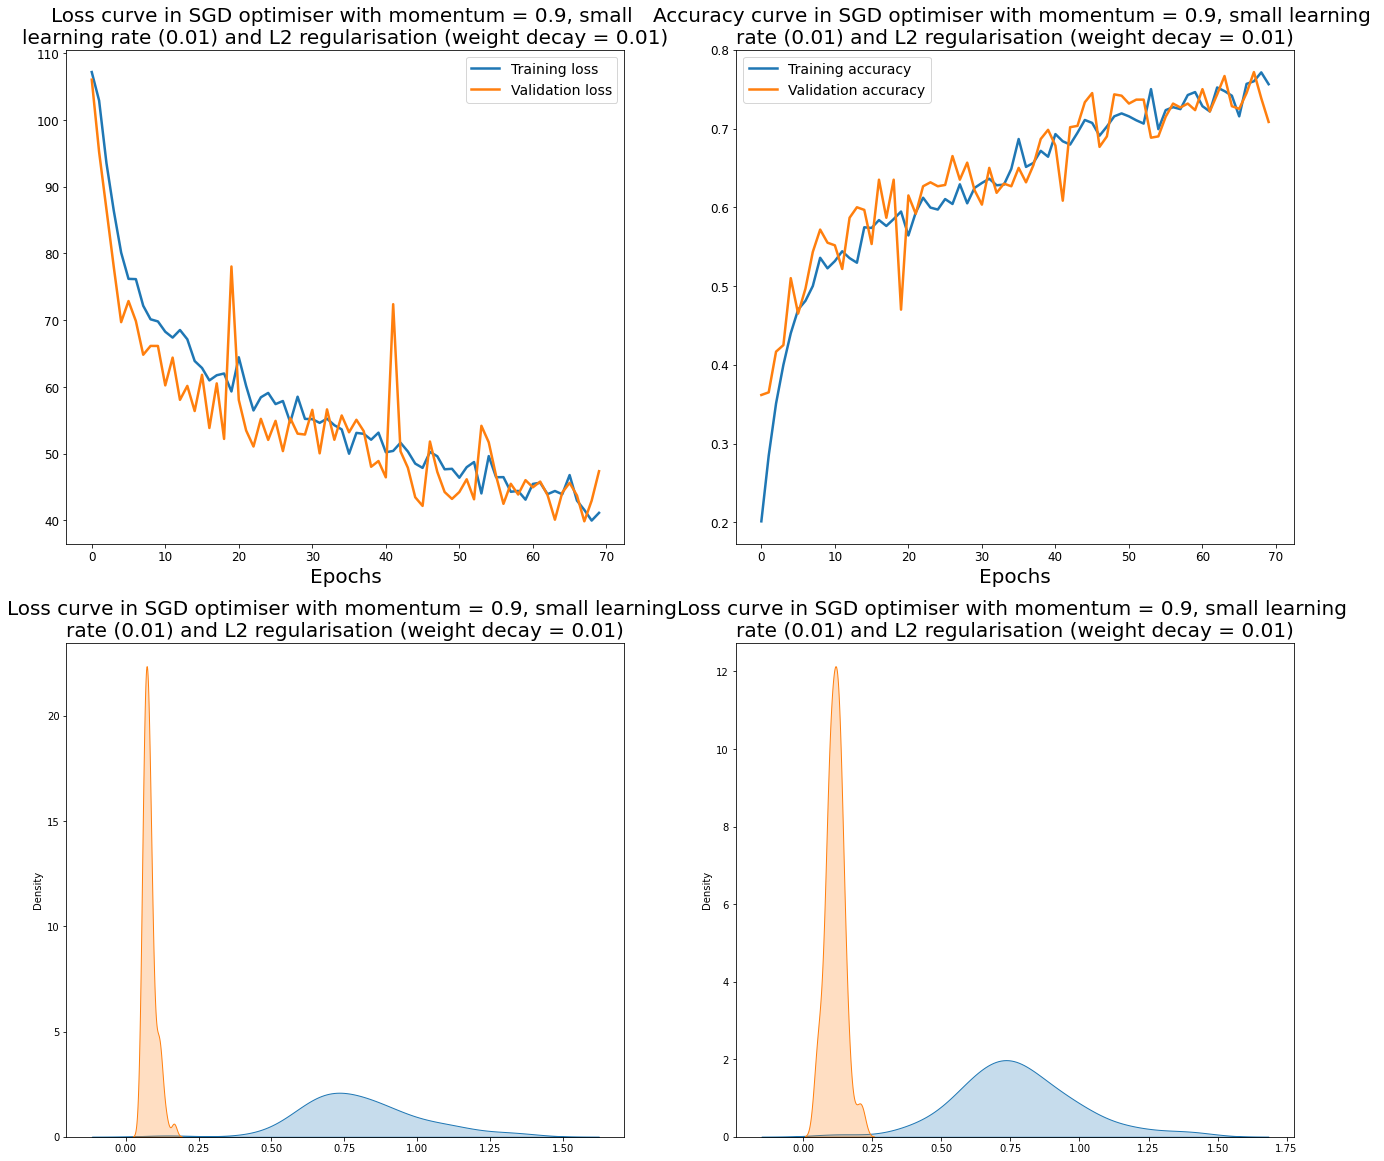

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in SGD optimiser with momentum = 0.9, small \nlearning rate (0.01) and L2 regularisation (weight decay = 0.01)", size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in SGD optimiser with momentum = 0.9, small learning \nrate (0.01) and L2 regularisation (weight decay = 0.01)", size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.title("Loss curve in SGD optimiser with momentum = 0.9, small learning \nrate (0.01) and L2 regularisation (weight decay = 0.01)", size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.title("Loss curve in SGD optimiser with momentum = 0.9, small learning \nrate (0.01) and L2 regularisation (weight decay = 0.01)", size=20)

# Testing the model

In [ ]:
model4.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel4.pt'))

# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model4.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model4(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.505219

Test Accuracy of mountain: 86% (380/437)
Test Accuracy of   sea: 95% (452/474)
Test Accuracy of glacier: 85% (472/553)
Test Accuracy of street: 74% (390/525)
Test Accuracy of buildings: 68% (347/510)
Test Accuracy of forest: 85% (430/501)

Test Accuracy (Overall): 82% (2471/3000)


# Evaluating the model

Text(69.0, 0.5, 'TRUE')

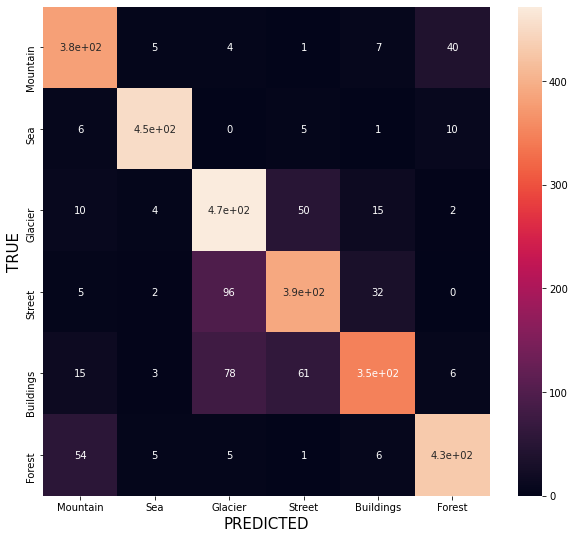

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model4(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(confusion_matrix, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

# Adadelta optimiser

In its parameter update rule, Adagrad modifies the general learning rate $\eta$ at each time step t for every parameter $\theta_i$ based on the past gradients that have been computed for $\theta_i$
:


$\theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i}$

In Adadelta, the running average $E[g^2]_t$ at time step t is calculated as the sum of only the previous average and the current gradient:
$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g^2_t$

$- \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i}$ is replaced by
$- \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}$

# 3. Using Adadelta optimiser with large learning rate (0.1)

In [ ]:
model5 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer2 = optim.Adadelta(model5.parameters(), lr = 0.1)


if train_on_gpu:
    model5.cuda()
    print(train_on_gpu)

print(model5)

True
IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 70

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model5.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer2.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model5(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer2.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model5.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model5(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model5.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model5.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model5.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model5.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model5.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel5.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 107.414453 	Validation Loss: 106.935596 
		Training Accuracy: 0.176250 	Validation Accuracy: 0.185000
Validation loss decreased (inf --> 106.935596).  Saving model ...
Epoch: 2 	Training Loss: 104.903959 	Validation Loss: 98.363866 
		Training Accuracy: 0.245417 	Validation Accuracy: 0.365000
Validation loss decreased (106.935596 --> 98.363866).  Saving model ...
Epoch: 3 	Training Loss: 98.998498 	Validation Loss: 91.346206 
		Training Accuracy: 0.299583 	Validation Accuracy: 0.391667
Validation loss decreased (98.363866 --> 91.346206).  Saving model ...
Epoch: 4 	Training Loss: 93.279590 	Validation Loss: 83.707090 
		Training Accuracy: 0.352500 	Validation Accuracy: 0.388333
Validation loss decreased (91.346206 --> 83.707090).  Saving model ...
Epoch: 5 	Training Loss: 88.274388 	Validation Loss: 79.295664 
		Training Accuracy: 0.398750 	Validation Accuracy: 0.453333
Validation loss decreased (83.707090 --> 79.295664).  Saving model ...
Epoch: 6 	Training Lo

# Plotting training/validation losses and accuracy 
# and gradients of weight and bias

Text(0.5, 1.0, 'Distribution of gradients in last fully connected layer in \n Adadelta optimiser with large learning rate (0.1)')

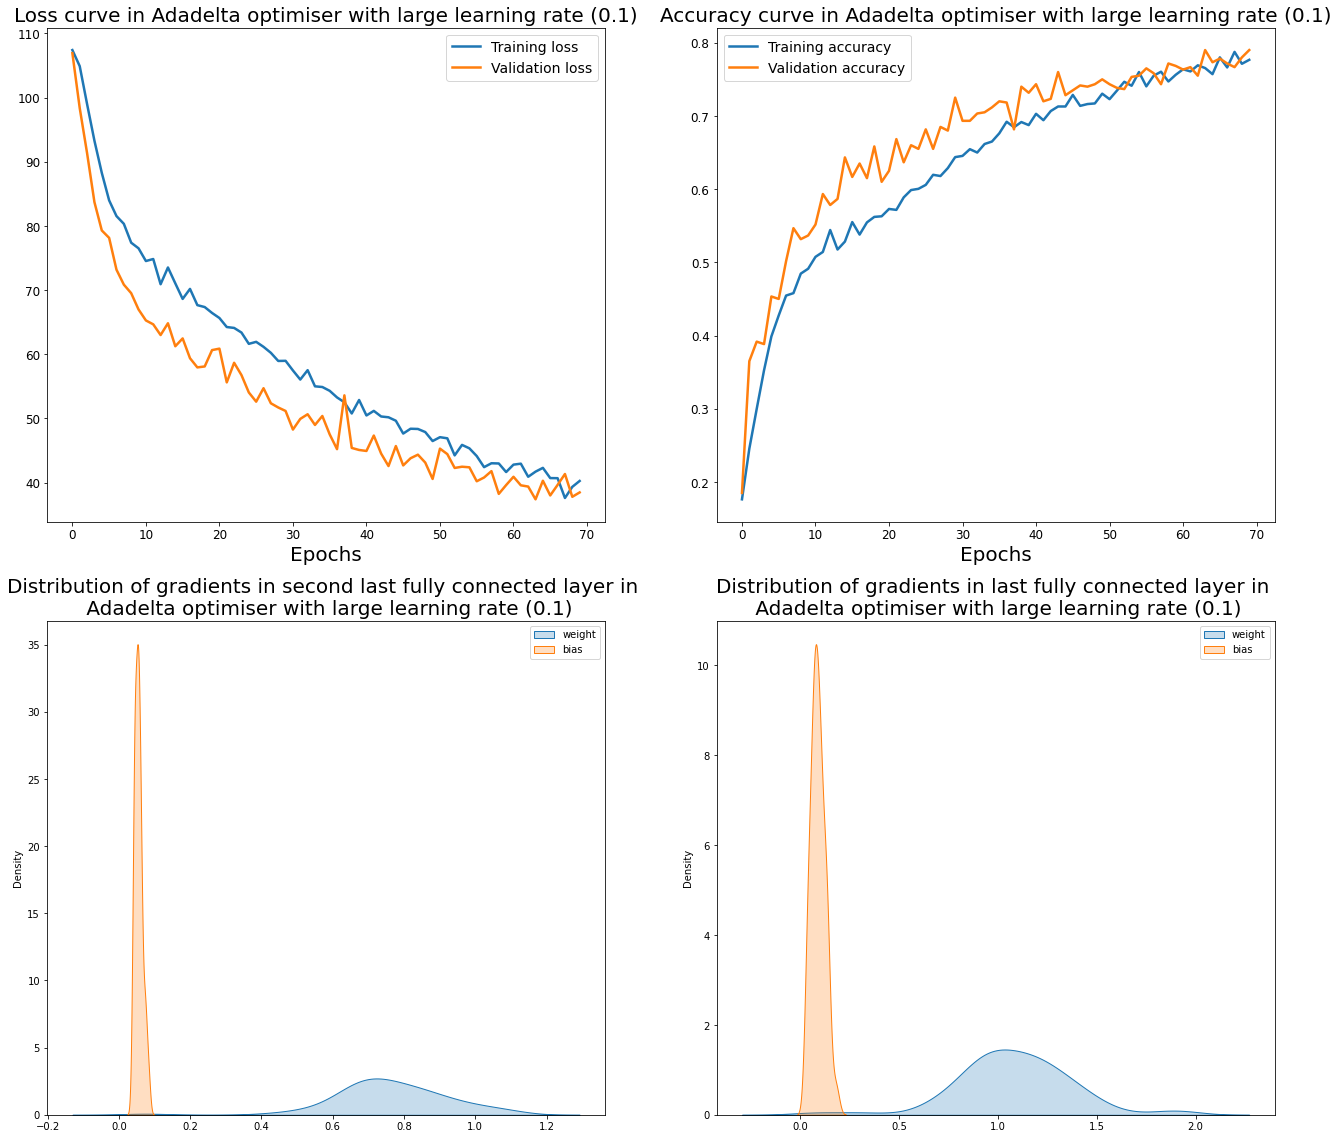

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in Adadelta optimiser with large learning rate (0.1)",size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in Adadelta optimiser with large learning rate (0.1)",size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in second last fully connected layer in \n Adadelta optimiser with large learning rate (0.1)",size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in last fully connected layer in \n Adadelta optimiser with large learning rate (0.1)",size=20)

# Testing the model

In [ ]:
model5.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel5.pt'))

<All keys matched successfully>

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model5.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model5(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.521274

Test Accuracy of mountain: 79% (347/437)
Test Accuracy of   sea: 95% (453/474)
Test Accuracy of glacier: 84% (469/553)
Test Accuracy of street: 76% (403/525)
Test Accuracy of buildings: 67% (345/510)
Test Accuracy of forest: 85% (428/501)

Test Accuracy (Overall): 81% (2445/3000)


# Evaluating the model

Text(69.0, 0.5, 'TRUE')

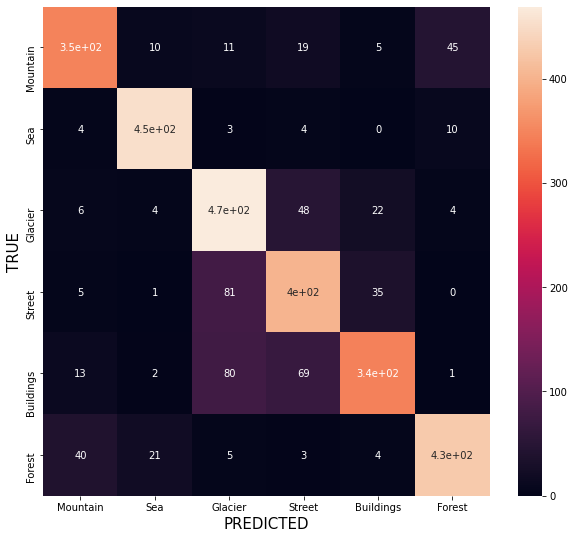

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model5(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm_adam = confusion_matrix.numpy()
plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(cm_adam, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

# 4. Using RMSprop optimiser with large learning rate (0.1)

In [46]:
model6 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.RMSprop(model6.parameters(), lr = 0.05)

if train_on_gpu:
    model6.cuda()

print(model6)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [48]:
# number of epochs to train the model
n_epochs = 70

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model6.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model6(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model6.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model6(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model6.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model6.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model6.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model6.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model6.state_dict(), '/content/model_intel6.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 107.622028 	Validation Loss: 107.463070 
		Training Accuracy: 0.172500 	Validation Accuracy: 0.158333
Validation loss decreased (inf --> 107.463070).  Saving model ...
Epoch: 2 	Training Loss: 109.635595 	Validation Loss: 107.516643 
		Training Accuracy: 0.167083 	Validation Accuracy: 0.158333
Epoch: 3 	Training Loss: 107.546134 	Validation Loss: 107.597566 
		Training Accuracy: 0.172917 	Validation Accuracy: 0.188333
Epoch: 4 	Training Loss: 107.623791 	Validation Loss: 107.689955 
		Training Accuracy: 0.167500 	Validation Accuracy: 0.188333
Epoch: 5 	Training Loss: 107.609955 	Validation Loss: 108.563082 
		Training Accuracy: 0.177083 	Validation Accuracy: 0.188333
Epoch: 6 	Training Loss: 107.571087 	Validation Loss: 107.676617 
		Training Accuracy: 0.178333 	Validation Accuracy: 0.188333
Epoch: 7 	Training Loss: 124.008576 	Validation Loss: 107.618729 
		Training Accuracy: 0.174583 	Validation Accuracy: 0.161667
Epoch: 8 	Training Loss: 107.646258 	Validati

KeyboardInterrupt: ignored

# Plotting training/validation losses and accuracy
# and gradients of weight and bias

Text(0.5, 1.0, 'Distribution of gradients in last fully connected layer in \n RMSprop optimiser with large learning rate (0.1)')

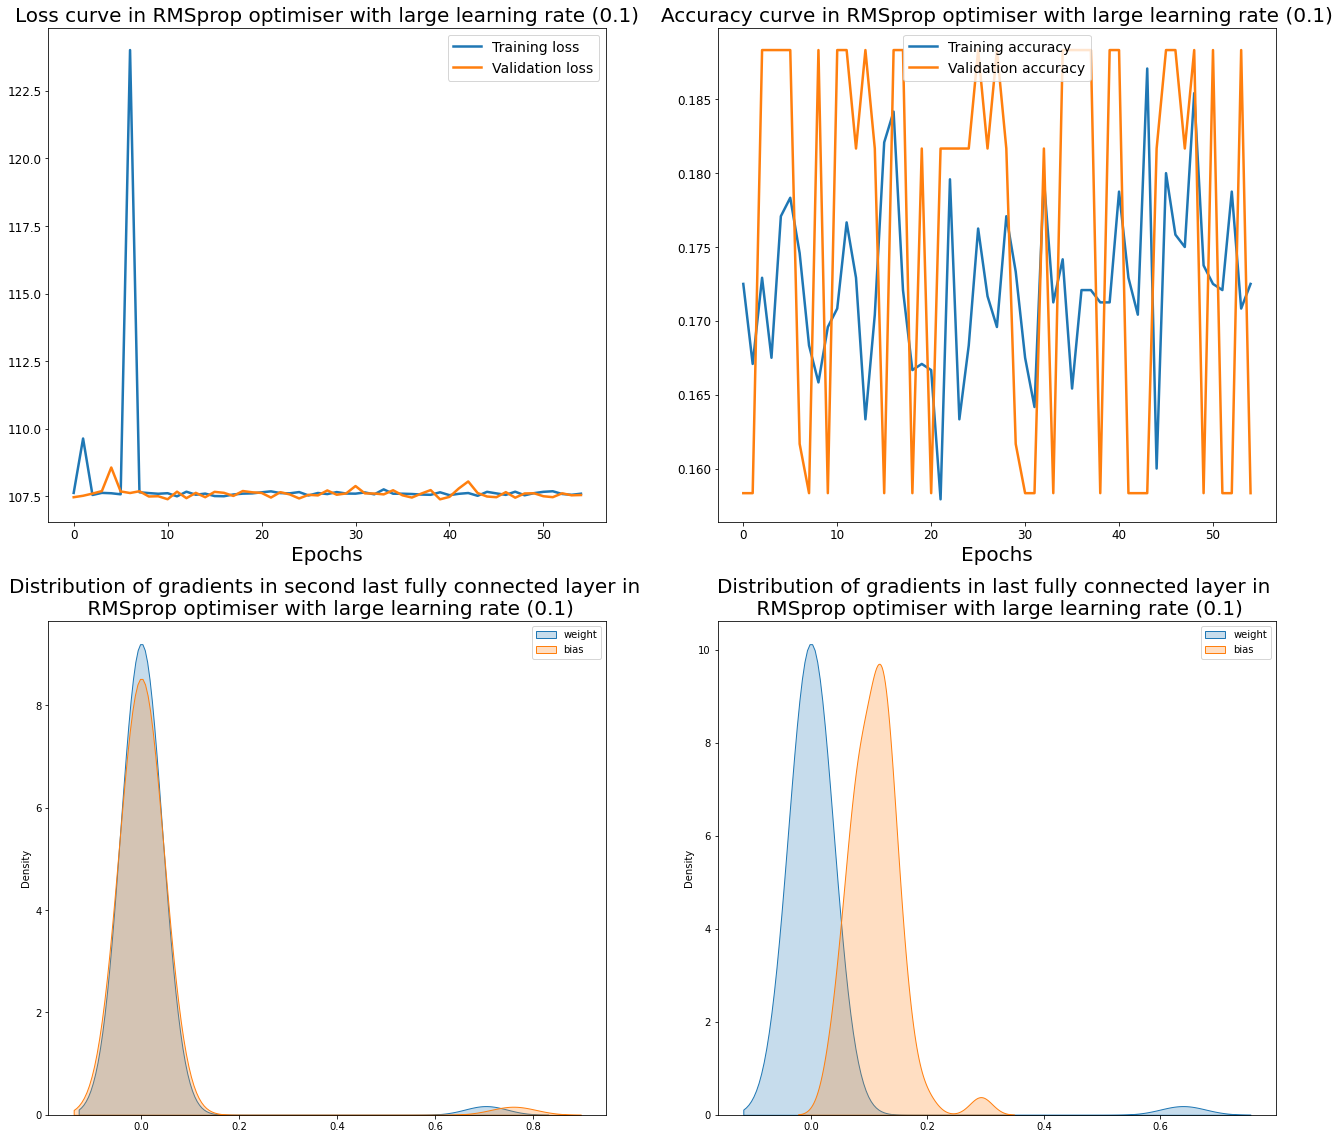

In [49]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in RMSprop optimiser with large learning rate (0.1)",size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in RMSprop optimiser with large learning rate (0.1)",size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in second last fully connected layer in \n RMSprop optimiser with large learning rate (0.1)",size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.legend(['weight','bias'])
plt.title("Distribution of gradients in last fully connected layer in \n RMSprop optimiser with large learning rate (0.1)",size=20)

# Adam optimiser

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $v_t$ like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum.
\begin{align} 
\begin{split} 
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
\end{split} 
\end{align}

\begin{align} 
\begin{split} 
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split} 
\end{align}

Updation rule :         $\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$

# 5 i) Using Adam optimiser

In [ ]:
model7 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.Adam(model7.parameters(),lr = 0.001)

if train_on_gpu:
    model7.cuda()

print(model7)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model7.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model7(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model7.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model7(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model7.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model7.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model7.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model7.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model7.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel7.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 101.622197 	Validation Loss: 84.281110 
		Training Accuracy: 0.263750 	Validation Accuracy: 0.410000
Validation loss decreased (inf --> 84.281110).  Saving model ...
Epoch: 2 	Training Loss: 87.838729 	Validation Loss: 78.201763 
		Training Accuracy: 0.398333 	Validation Accuracy: 0.526667
Validation loss decreased (84.281110 --> 78.201763).  Saving model ...
Epoch: 3 	Training Loss: 78.674687 	Validation Loss: 66.995300 
		Training Accuracy: 0.459167 	Validation Accuracy: 0.550000
Validation loss decreased (78.201763 --> 66.995300).  Saving model ...
Epoch: 4 	Training Loss: 73.650635 	Validation Loss: 63.555036 
		Training Accuracy: 0.487500 	Validation Accuracy: 0.605000
Validation loss decreased (66.995300 --> 63.555036).  Saving model ...
Epoch: 5 	Training Loss: 69.320652 	Validation Loss: 65.933746 
		Training Accuracy: 0.520000 	Validation Accuracy: 0.555000
Epoch: 6 	Training Loss: 65.255084 	Validation Loss: 61.184795 
		Training Accuracy: 0.556250 	V

# Plotting training/validation losses and accuracy
# and gradients of weight and bias

Text(0.5, 1.0, 'Loss curve in Adam optimiser, learning rate = 0.01')

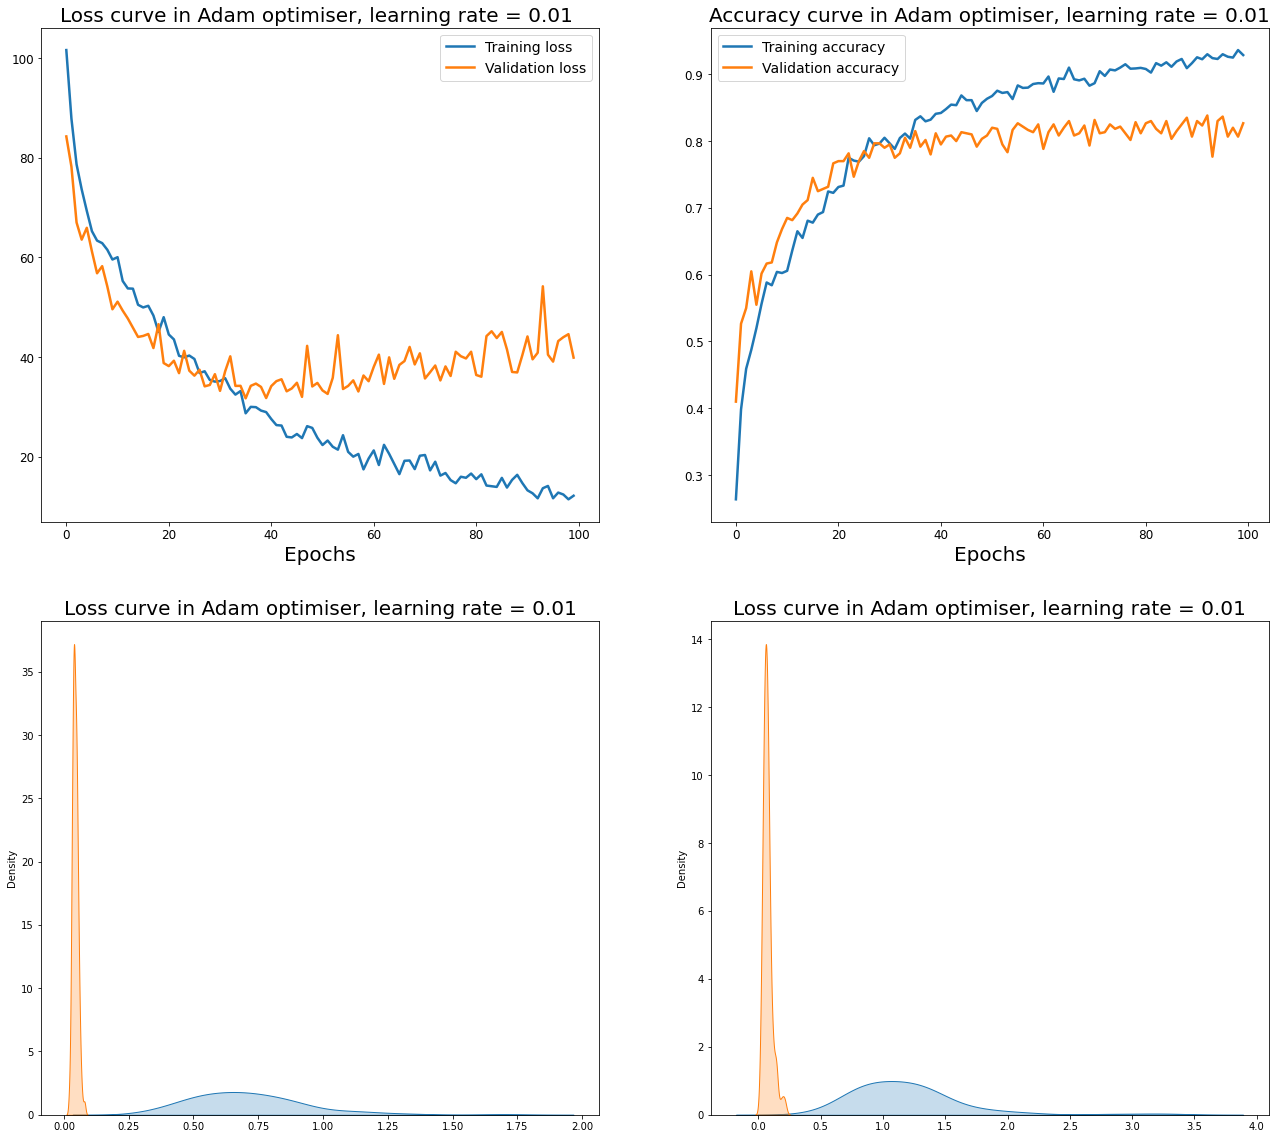

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in Adam optimiser, learning rate = 0.01 ", size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in Adam optimiser, learning rate = 0.01", size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.title("Loss curve in Adam optimiser, learning rate = 0.01", size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.title("Loss curve in Adam optimiser, learning rate = 0.01", size=20)

# Testing the model

In [ ]:
model7.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel7.pt'))

<All keys matched successfully>

# Test Accuracy

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model7.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model7(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.354296

Test Accuracy of mountain: 90% (397/437)
Test Accuracy of   sea: 98% (467/474)
Test Accuracy of glacier: 88% (489/553)
Test Accuracy of street: 74% (393/525)
Test Accuracy of buildings: 83% (425/510)
Test Accuracy of forest: 94% (471/501)

Test Accuracy (Overall): 88% (2642/3000)


Text(69.0, 0.5, 'TRUE')

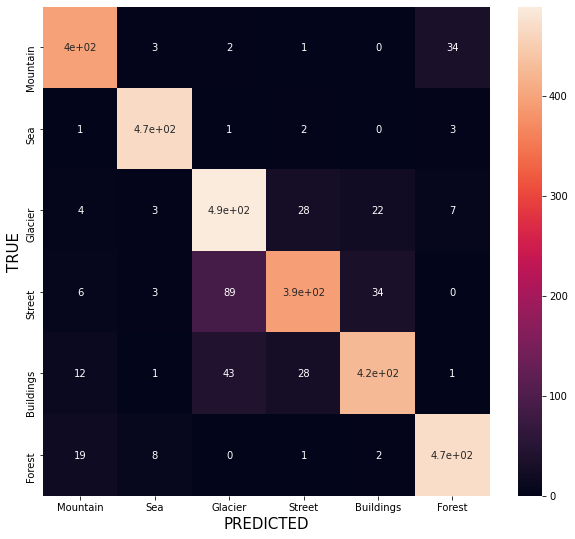

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model7(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm_qhm = confusion_matrix.numpy()
plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(cm_qhm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)

# 5 ii) Using Adam optimiser with L2 regularisation (weight decay = 0.01)

In [ ]:
model8 = IntelImageNet()

# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.Adam(model8.parameters(),lr = 0.001, weight_decay = 0.01)

if train_on_gpu:
    model8.cuda()

print(model8)

IntelImageNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training and validating the model

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
bias_grads1, bias_grads2 = [], []
weight_grads1, weight_grads2 = [], []
for epoch in range(1, n_epochs+1):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model8.train()
    for data, target in train_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model8(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    #scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model8.eval()
    for data, target in valid_loader:
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model8(data)
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    weight_grads1.append(np.linalg.norm(model8.fc2.weight.grad.cpu().numpy()))
    bias_grads1.append(np.linalg.norm(model8.fc2.bias.grad.cpu().numpy()))
    weight_grads2.append(np.linalg.norm(model8.fc3.weight.grad.cpu().numpy()))
    bias_grads2.append(np.linalg.norm(model8.fc3.bias.grad.cpu().numpy()))

    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model8.state_dict(), '/home/sysadm/Downloads/intel_images/models/model_intel8.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 102.680272 	Validation Loss: 92.469012 
		Training Accuracy: 0.262500 	Validation Accuracy: 0.375000
Validation loss decreased (inf --> 92.469012).  Saving model ...
Epoch: 2 	Training Loss: 90.129073 	Validation Loss: 78.769273 
		Training Accuracy: 0.384583 	Validation Accuracy: 0.443333
Validation loss decreased (92.469012 --> 78.769273).  Saving model ...
Epoch: 3 	Training Loss: 83.696149 	Validation Loss: 73.749330 
		Training Accuracy: 0.437083 	Validation Accuracy: 0.523333
Validation loss decreased (78.769273 --> 73.749330).  Saving model ...
Epoch: 4 	Training Loss: 78.557949 	Validation Loss: 67.399884 
		Training Accuracy: 0.487083 	Validation Accuracy: 0.540000
Validation loss decreased (73.749330 --> 67.399884).  Saving model ...
Epoch: 5 	Training Loss: 76.598994 	Validation Loss: 63.739621 
		Training Accuracy: 0.485833 	Validation Accuracy: 0.593333
Validation loss decreased (67.399884 --> 63.739621).  Saving model ...
Epoch: 6 	Training Loss: 

# Plotting training/validation losses and accuracy
# and gradients of weight and bias

Text(0.5, 1.0, 'Loss curve in Adam optimiser with learning rate = 0.01 \n and weight decay = 0.01')

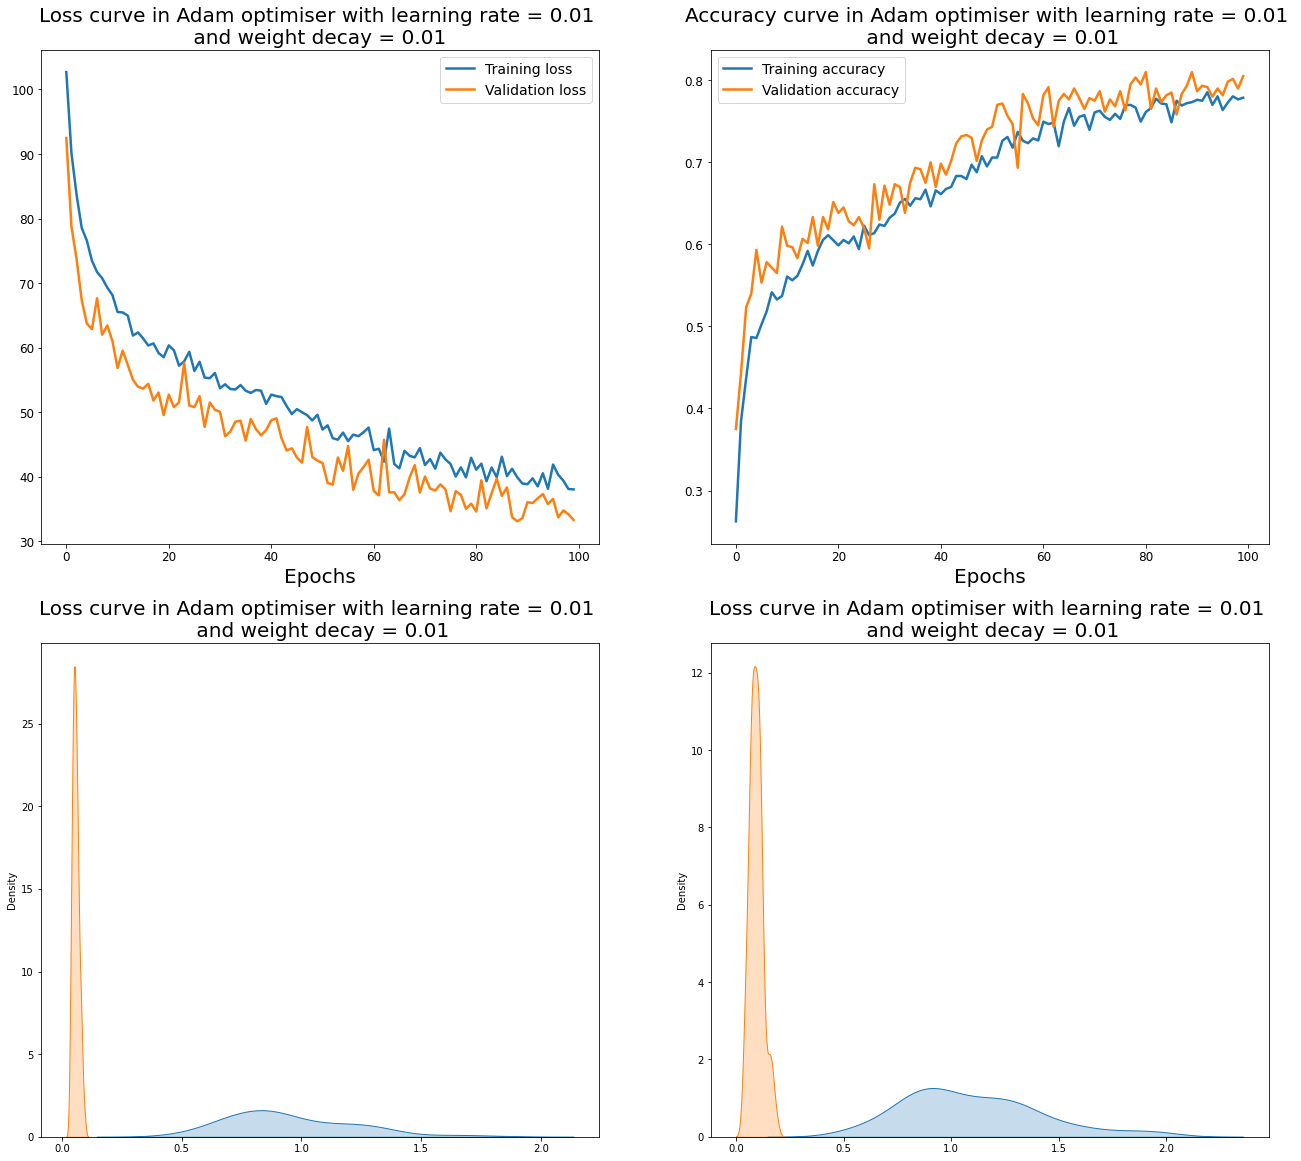

In [ ]:
plt.figure(figsize=(22,20))

plt.subplot(221)
plt.plot(train_losses,linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
#plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Loss curve in Adam optimiser with learning rate = 0.01 \n and weight decay = 0.01 ", size=20)

plt.subplot(222)
plt.plot(train_acc, linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc, linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Accuracy curve in Adam optimiser with learning rate = 0.01 \n and weight decay = 0.01", size=20)

plt.subplot(223)
l1, l2 = [], []
for i in weight_grads1:
  l1.append(i.item())    
for j in bias_grads1:
  l2.append(j.item())
sns.kdeplot(l1, shade=True)
sns.kdeplot(l2, shade=True)
plt.title("Loss curve in Adam optimiser with learning rate = 0.01 \n and weight decay = 0.01", size=20)

plt.subplot(224)
l3, l4 = [], []
for i in weight_grads2:
  l3.append(i.item())    
for j in bias_grads2:
  l4.append(j.item())
sns.kdeplot(l3, shade=True)
sns.kdeplot(l4, shade=True)
plt.title("Loss curve in Adam optimiser with learning rate = 0.01 \n and weight decay = 0.01", size=20)

# Testing the model


In [ ]:
model8.load_state_dict(torch.load('/home/sysadm/Downloads/intel_images/models/model_intel8.pt'))

# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model8.eval()
# iterating over test data
for data, target in test_loader:
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model8(data)
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.505828

Test Accuracy of mountain: 85% (375/437)
Test Accuracy of   sea: 93% (445/474)
Test Accuracy of glacier: 85% (471/553)
Test Accuracy of street: 54% (287/525)
Test Accuracy of buildings: 88% (450/510)
Test Accuracy of forest: 85% (428/501)

Test Accuracy (Overall): 81% (2456/3000)


# Evaluating the model

Text(69.0, 0.5, 'TRUE')

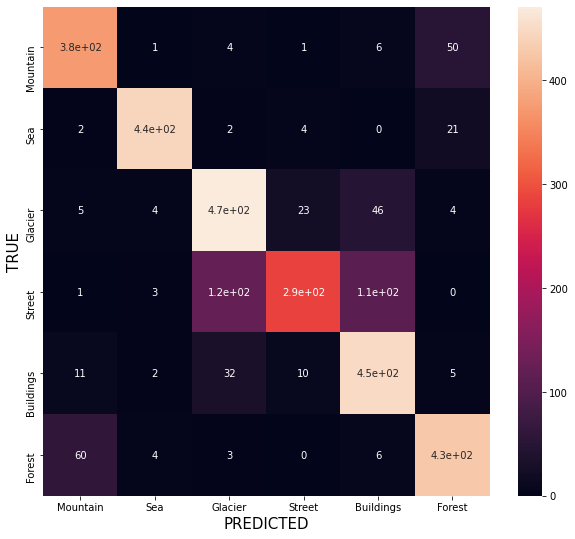

In [ ]:
confusion_matrix = torch.zeros(6,6)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        output = model8(data)
        _, preds = torch.max(output, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(10,9))
xticks = np.array([str(i).capitalize() for i in classes])
sns.heatmap(confusion_matrix, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15)